
# Predict Local Epidemics of Dengue Fever
Can you predict local epidemics of dengue fever?
Dengue fever is a mosquito-borne disease that occurs in tropical and sub-tropical parts of theworld. In mild cases, symptoms are similar to the flu: fever, rash, and muscle and joint pain. Insevere cases, dengue fever can cause severe bleeding, low blood pressure, and even death.

Because it is carried by mosquitoes, the transmission dynamics of dengue are related to climatevariables such as temperature and precipitation. Although the relationship to climate is complex,a growing number of scientists argue that climate change is likely to produce distributional shiftsthat will have significant public health implications worldwide.

In recent years dengue fever has been spreading. Historically, the disease has been most prevalent in Southeast Asia and the Pacific islands. These days many of the nearly half billion cases per year are occurring in Latin America. Your goal is to predict the total_cases label for each (city, year, weekofyear) in the test set. There are two cities, San Juan and Iquitos, with test data for each city spanning 5 and 3 years respectively.

# Steps:
1.Loading and preprocessing the data to understand its structure and the features included. Pre-processing the data by handling missing values, encoding categorical variables if necessary, and normalizing or standardizing features.
2.Exploratory Data Analysis (EDA) to uncover patterns, anomalies, relationships, or trends.
3.Feature engineering if necessary to improve the predictive model.
4.Building predictive models using machine learning algorithms suitable for time series forecasting and regression problems.
5.Evaluating model performance using appropriate metrics.
6.Predicting dengue cases using the test dataset.

In [411]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import cumtrapz
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import PolynomialFeatures

### 1. Loading and Preprocessing the Data (Author: Cheng Yan)
Structured to effectively prepare a dataset for analysis by loading, merging, and preprocessing features and labels related to dengue fever cases. It includes functions for loading data from CSV files, where feature data is optionally combined with labels if provided. The preprocessing function then segments the data by city, and adjusts the training data by clipping its values to the range observed in the test data for specific columns. This method prevents potential data leakage and ensures that the training data does not contain out-of-range values which could mislead the model during training. Essentially, this approach maintains the integrity and generalizability of the model by ensuring that the training environment simulates real-world conditions as closely as possible.

In [412]:
# Define functions to load data
def load_data(feature_file, label_file=None):
    features = pd.read_csv(feature_file)
    if label_file:
        labels = pd.read_csv(label_file)
        features['total_cases'] = labels['total_cases']
    return features

# Function to process the features and labels
def process_data(features, test_features, to_trim):
    for city in ['sj', 'iq']:
        city_train = features[features.city == city].copy()
        city_test = test_features[test_features.city == city].copy()

        for col in to_trim:
            max_val = city_test[col].max()
            min_val = city_test[col].min()
            city_train[col] = city_train[col].clip(lower=min_val, upper=max_val)

        features.update(city_train)

    return features

# Load training and test data
train_features = load_data('dengue_features_train.csv', 'dengue_labels_train.csv')
test_features = load_data('dengue_features_test.csv')

# Specify columns to be trimmed
columns_to_trim = ['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
                   'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k',
                   'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_relative_humidity_percent',
                   'reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
                   'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c',
                   'station_precip_mm']

# Process the data
processed_data = process_data(train_features, test_features, columns_to_trim)

In [413]:
# Check the missing values in the processed data
processed_data.isnull().sum()

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_mi

### 2. Exploratory Data Analysis (Author: Guihua Zou, Cheng Yan)

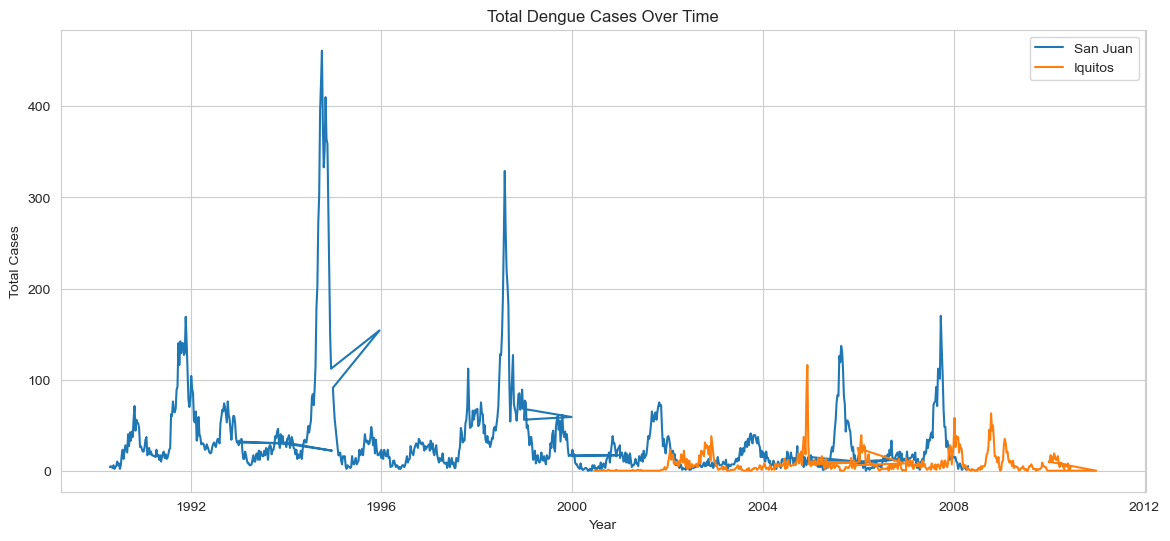

In [414]:
# Author: Guihua Zou
# Creating a date-like index from 'year' and 'weekofyear' for plotting
processed_data['date'] = processed_data.apply(lambda row: f"{int(row['year'])}-W{int(row['weekofyear'])-1}", axis=1)
processed_data['date'] = pd.to_datetime(processed_data['date'] + '-1', format='%Y-W%W-%w')

# Plotting the total dengue cases over time for both cities
plt.figure(figsize=(14, 6))
plt.plot(processed_data[processed_data['city'] == 'sj']['date'], processed_data[processed_data['city'] == 'sj']['total_cases'], label='San Juan')
plt.plot(processed_data[processed_data['city'] == 'iq']['date'], processed_data[processed_data['city'] == 'iq']['total_cases'], label='Iquitos')
plt.title('Total Dengue Cases Over Time')
plt.xlabel('Year')
plt.ylabel('Total Cases')
plt.legend()
plt.show()


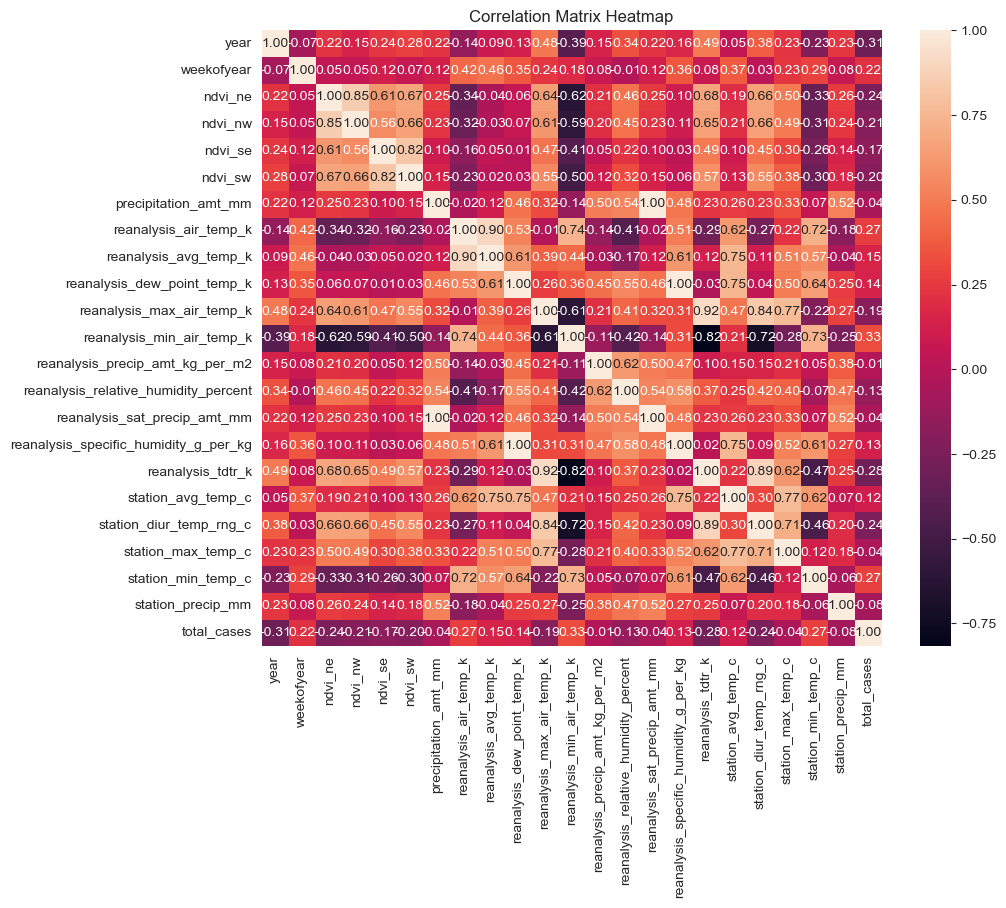

In [415]:
# Author: Guihua Zou
# Calculating correlation matrix for numerical data
corr_matrix = processed_data.select_dtypes(include=[np.number]).corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

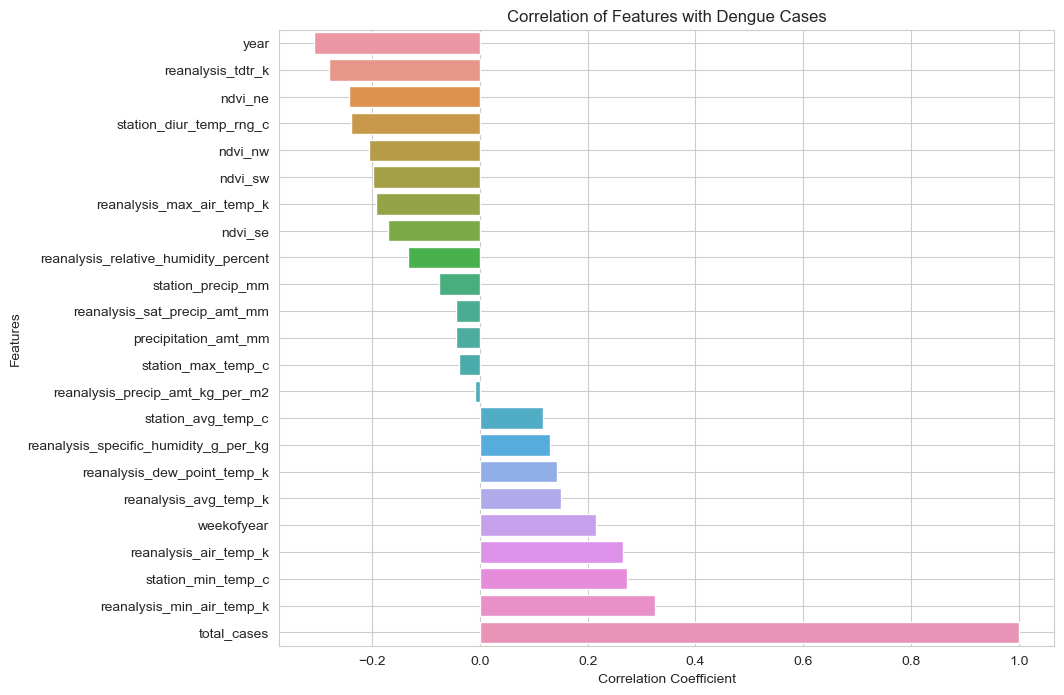

year                                    -0.306806
reanalysis_tdtr_k                       -0.279007
ndvi_ne                                 -0.242013
station_diur_temp_rng_c                 -0.238417
ndvi_nw                                 -0.205101
ndvi_sw                                 -0.198300
reanalysis_max_air_temp_k               -0.192317
ndvi_se                                 -0.170121
reanalysis_relative_humidity_percent    -0.133996
station_precip_mm                       -0.075575
reanalysis_sat_precip_amt_mm            -0.044522
precipitation_amt_mm                    -0.044522
station_max_temp_c                      -0.038964
reanalysis_precip_amt_kg_per_m2         -0.009578
station_avg_temp_c                       0.117526
reanalysis_specific_humidity_g_per_kg    0.129778
reanalysis_dew_point_temp_k              0.142901
reanalysis_avg_temp_k                    0.151522
weekofyear                               0.216452
reanalysis_air_temp_k                    0.265062


In [416]:
# Author: Guihua Zou
# Calculating correlation matrix and focusing on the correlation with 'total_cases'
correlation_matrix = processed_data.select_dtypes(include=[np.number]).corr()
correlations_with_dengue = correlation_matrix['total_cases'].sort_values()

# Plotting the correlations with dengue cases
plt.figure(figsize=(10, 8))
sns.barplot(x=correlations_with_dengue.values, y=correlations_with_dengue.index)
plt.title('Correlation of Features with Dengue Cases')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.grid(True)
plt.show()

# Output the sorted correlations for review
correlations_with_dengue

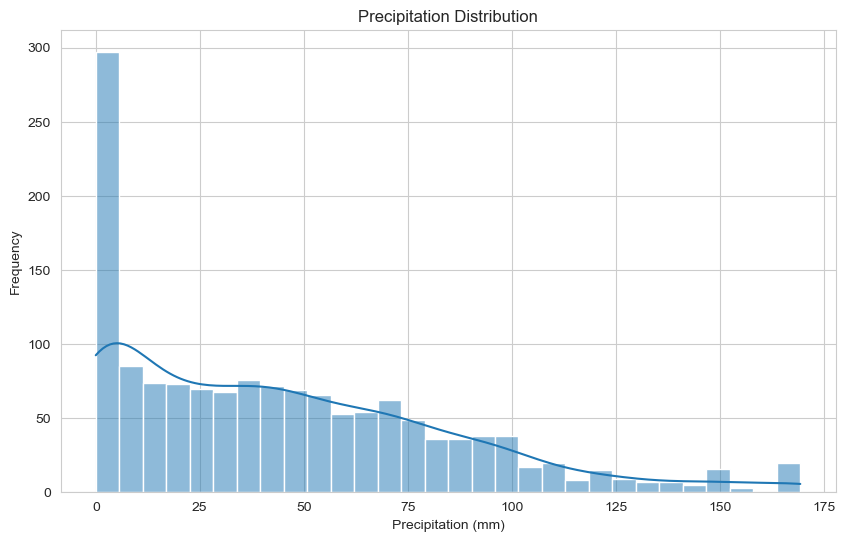

In [417]:
# Author: Cheng Yan
# Plotting the distribution of the precipitation amount
plt.figure(figsize=(10, 6))
sns.histplot(processed_data['precipitation_amt_mm'], bins=30, kde=True)
plt.title('Precipitation Distribution')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Frequency')
plt.show()

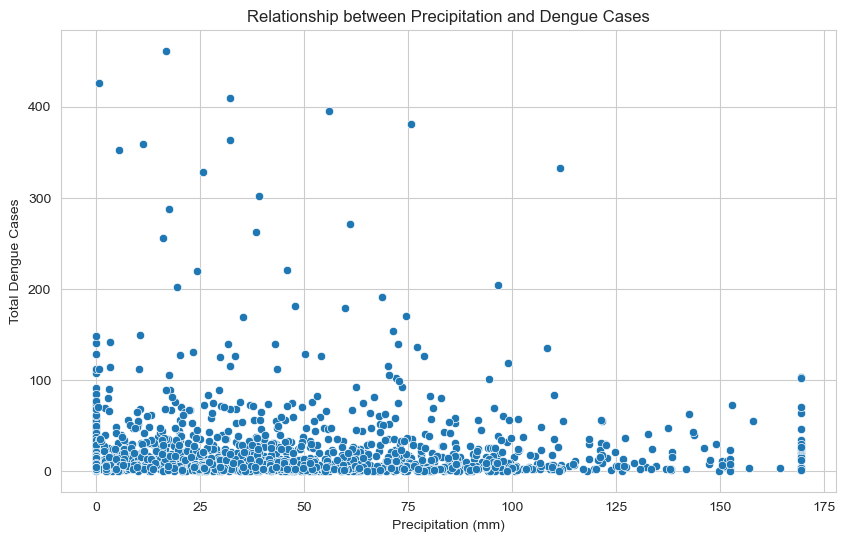

In [418]:
# Author: Cheng Yan
# Scatter plot of precipitation amount vs. total dengue cases
plt.figure(figsize=(10, 6))
sns.scatterplot(x=processed_data['precipitation_amt_mm'], y=processed_data['total_cases'])
plt.title('Relationship between Precipitation and Dengue Cases')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Total Dengue Cases')
plt.show()

### 3. Feature Engineering (Author: Guihua Zou)

1. Modify the week

    Because there may be errors in week numbering in the historical data (for example, the first week of the year may be incorrectly labeled as the week following week 52), this code block corrects for these weeks. This is achieved by increasing the number of weeks in a given year and correcting the number of weeks over 52 to 1 when needed, thus avoiding numbering errors across years.


2. Fill in missing values

    The use of linear interpolation to fill in missing values in the data helps maintain the continuity of the data and enables the model to process a more complete data set.


3. Scale and average the temperature data

    Standardize the different temperature-related features to the same scale (0 to 1) and calculate their average. This reduces inconsistencies between temperature features and reduces the model's dependence on specific temperature scales.


4. Create seasonal Boolean variables

    Create three seasonal indicators based on the week: slow season, slow season, and growing season. These variables help the model understand how different time periods of the year may affect the number of dengue cases.


5. Delete unnecessary columns

    Remove unwanted columns from the dataset and keep only features that may be useful for model predictions.


6. Add lag features

    Create lag features for variables such as temperature and humidity to capture the impact of past weeks' data on the previous week. This helps the model capture dynamic changes in time series data.


7. Forward fill

    For new hysteresis features, use forward fill to handle any missing values due to hysteresis.

#### 3.1 For City of San Juan

In [419]:
def adjust_week_number_sj(dataframe, is_training):
    """ Adjusts week numbers specifically for San Juan data """
    year_adjustments = {
        True: [1993] + list(range(1994, 1996)) + [1999, 2000, 2005, 2006],
        False: [2010, 2011, 2012]
    }

    dataframe['weekofyear_fixed'] = dataframe['weekofyear']
    for year in year_adjustments[is_training]:
        dataframe.loc[dataframe['year'] == year, 'weekofyear_fixed'] += 1
    dataframe['weekofyear'] = np.where(dataframe['weekofyear_fixed'] > 52, 1, dataframe['weekofyear_fixed'])
    return dataframe

def create_seasonal_indicators_sj(dataframe):
    """ Creates seasonal binary indicators for San Juan """
    season_cutoffs = [11, 30]
    dataframe['slowdown_season'] = np.where(dataframe['weekofyear'] < season_cutoffs[0], 1, 0)
    dataframe['lull_season'] = np.where((dataframe['weekofyear'] >= season_cutoffs[0]) &
                                        (dataframe['weekofyear'] < season_cutoffs[1]), 1, 0)
    dataframe['rampup_season'] = np.where(dataframe['weekofyear'] >= season_cutoffs[1], 1, 0)
    return dataframe

def calculate_average_temperature(dataframe):
    """ Calculates the average temperature from relevant temperature columns """
    temperature_columns = ['reanalysis_max_air_temp_k', 'station_avg_temp_c', 'reanalysis_min_air_temp_k']  # Adjust as necessary
    if set(temperature_columns).issubset(dataframe.columns):
        dataframe['average_temperature'] = dataframe[temperature_columns].mean(axis=1)
    return dataframe

def prepare_san_juan_data(data, training_mode=True):
    """ Preprocesses the San Juan dataset for training or prediction """
    data = adjust_week_number_sj(data, training_mode)
    data = data.interpolate(method='linear')
    data = create_seasonal_indicators_sj(data)
    data = calculate_average_temperature(data)

    # Define necessary columns including total_cases conditionally if it exists
    essential_columns = ['slowdown_season', 'lull_season', 'rampup_season',
                         'station_max_temp_c', 'average_temperature', 'reanalysis_relative_humidity_percent',
                         'reanalysis_specific_humidity_g_per_kg', 'reanalysis_precip_amt_kg_per_m2']
    if 'total_cases' in data.columns:
        essential_columns.insert(0, 'total_cases')

    data = data[essential_columns]

    # Add shifted features for the past 3 weeks
    features_to_shift = ['station_max_temp_c', 'average_temperature', 'reanalysis_relative_humidity_percent',
                         'reanalysis_specific_humidity_g_per_kg', 'reanalysis_precip_amt_kg_per_m2']
    for feature in features_to_shift:
        for lag in range(1, 4):
            data[f'{feature}_{lag}lag'] = data[feature].shift(-lag)
    data = data.fillna(method='ffill')

    return data

# Extract and print the shape of data for city 'sj'
sj_data = processed_data[processed_data.city == 'sj'].copy()

# Applying the modular function to the San Juan data
modular_sj_data = prepare_san_juan_data(sj_data)
modular_sj_data.shape


(936, 24)

In [420]:
# Split the data into features and target variable
from sklearn.model_selection import train_test_split

# Prepare feature and target datasets
sj_features = modular_sj_data.drop(['total_cases'], axis=1)
sj_target = modular_sj_data['total_cases']

# Split the datasets into training and testing sets
X_train_sj, X_test_sj, y_train_sj, y_test_sj = train_test_split(
    sj_features, sj_target, test_size=0.3, random_state=42)  # Added random_state for reproducibility

# Print the shapes of the training and testing datasets
X_train_sj.shape, X_test_sj.shape

((655, 23), (281, 23))

#### 3.2 For City of Iquitos

In [421]:
def adjust_week_number_iq(dataframe, is_training):
    """ Adjusts week numbers specifically for Iquitos data """
    year_adjustments = {
        True: [2005, 2006, 2010],
        False: [2011, 2012]
    }

    dataframe['weekofyear_fixed'] = dataframe['weekofyear']
    for year in year_adjustments[is_training]:
        dataframe.loc[dataframe['year'] == year, 'weekofyear_fixed'] += 1
    dataframe['weekofyear'] = np.where(dataframe['weekofyear_fixed'] > 52, 1, dataframe['weekofyear_fixed'])
    return dataframe

def create_seasonal_indicators_iq(dataframe):
    """ Creates seasonal binary indicators for Iquitos """
    season_cutoffs = [12, 24, 36]
    dataframe['fall'] = np.where(dataframe['weekofyear'] < season_cutoffs[0], 1, 0)
    dataframe['winter'] = np.where((dataframe['weekofyear'] >= season_cutoffs[0]) &
                                   (dataframe['weekofyear'] < season_cutoffs[1]), 1, 0)
    dataframe['spring'] = np.where((dataframe['weekofyear'] >= season_cutoffs[1]) &
                                   (dataframe['weekofyear'] < season_cutoffs[2]), 1, 0)
    dataframe['summer'] = np.where(dataframe['weekofyear'] >= season_cutoffs[2], 1, 0)
    return dataframe

def prepare_iquitos_data(data, training_mode=True):
    """ Preprocesses the Iquitos dataset for training or prediction """
    data = adjust_week_number_iq(data, training_mode)
    data = data.interpolate(method='linear')
    data = create_seasonal_indicators_iq(data)

    # Define necessary columns including total_cases conditionally if it exists
    essential_columns = ['spring', 'summer', 'fall', 'winter', 'station_avg_temp_c',
                         'reanalysis_min_air_temp_k', 'station_min_temp_c', 'reanalysis_dew_point_temp_k',
                         'reanalysis_tdtr_k', 'reanalysis_specific_humidity_g_per_kg', 'precipitation_amt_mm']
    if 'total_cases' in data.columns:
        essential_columns.insert(0, 'total_cases')

    data = data[essential_columns]

    # Add shifted features for the past 3 weeks
    features_to_shift = ['station_avg_temp_c', 'reanalysis_min_air_temp_k', 'station_min_temp_c',
                         'reanalysis_dew_point_temp_k', 'reanalysis_tdtr_k',
                         'reanalysis_specific_humidity_g_per_kg', 'precipitation_amt_mm']
    for feature in features_to_shift:
        for lag in range(1, 4):
            data[f'{feature}_{lag}lag'] = data[feature].shift(-lag)
    data = data.fillna(method='ffill')

    return data

# Extract IQ data from the processed main dataset
iq_data = processed_data[processed_data.city == 'iq'].copy()

# Apply the processing function to IQ data
processed_iq = prepare_iquitos_data(iq_data)
processed_iq.shape


(520, 33)

In [422]:
# Split the data into features and target variable
# Prepare feature and target datasets for IQ data
iq_features = processed_iq.drop(['total_cases'], axis=1)
iq_target = processed_iq['total_cases']

# Split the datasets into training and testing sets for IQ data
X_train_iq, X_test_iq, y_train_iq, y_test_iq = train_test_split(
    iq_features, iq_target, test_size=0.3, random_state=42)  # Using the same random_state for consistency

# Print the shapes of the training and testing datasets for IQ data
X_train_iq.shape, X_test_iq.shape


((364, 32), (156, 32))

### 4. Building Predictive Models (Author: Guihua Zou, Cheng Yan, Xuanhong Luo)
* Random Forest Regressor (Author: Guihua Zou)
* Linear Regression (Author: Guihua Zou)
* Gradient Boosting Regressor (Author: Cheng Yan)
* ANN (Author: Cheng Yan)
* Support Vector Regressor (Author: Xuanhong Luo)

#### 4.1 Random Forest Regressor (Author: Guihua Zou)

In [423]:
"""
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Define the parameters for grid search with the appropriate prefix for the RandomForestRegressor
param_grid = {
    'regressor__max_depth': [5, 10, 20, 35, 50],
    'regressor__max_features': [2, 5, 'auto'],
    'regressor__min_samples_leaf': [2, 3, 4],
    'regressor__min_samples_split': [2, 3, 4],
    'regressor__n_estimators': [100, 200, 300]
}

# Define the model pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Use median to impute missing values
    ('regressor', RandomForestRegressor(criterion='absolute_error'))
])

# Update the grid search to use the pipeline
gs_sj = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, n_jobs=-1)
gs_iq = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, n_jobs=-1)

# Fit the grid search to the data for San Juan and Iquitos
gs_sj.fit(X_train_sj, y_train_sj)
gs_iq.fit(X_train_iq, y_train_iq)

# Output the best parameters found and the time elapsed
print("Best parameters for San Juan:", gs_sj.best_params_)
print("Best parameters for Iquitos:", gs_iq.best_params_)
"""

'\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.impute import SimpleImputer\n\n# Define the parameters for grid search with the appropriate prefix for the RandomForestRegressor\nparam_grid = {\n    \'regressor__max_depth\': [5, 10, 20, 35, 50],\n    \'regressor__max_features\': [2, 5, \'auto\'],\n    \'regressor__min_samples_leaf\': [2, 3, 4],\n    \'regressor__min_samples_split\': [2, 3, 4],\n    \'regressor__n_estimators\': [100, 200, 300]\n}\n\n# Define the model pipeline\npipeline = Pipeline([\n    (\'imputer\', SimpleImputer(strategy=\'median\')),  # Use median to impute missing values\n    (\'regressor\', RandomForestRegressor(criterion=\'absolute_error\'))\n])\n\n# Update the grid search to use the pipeline\ngs_sj = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, n_jobs=-1)\ngs_iq = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, n_jobs=-1)\n\n# Fit the grid search to the data for San Juan and Iquitos\ngs_sj.fit(X_train_sj, y_train_sj)\ngs_iq.f

In [424]:
# Predict total cases
from sklearn.ensemble import RandomForestRegressor

# Setting up RandomForest parameters based on earlier optimization
params_san_juan = {
    'max_depth': 35,
    'max_features': 5,
    'min_samples_leaf': 3,
    'min_samples_split': 2,
    'n_estimators': 100,
    'criterion': 'absolute_error'
}

params_iquitos = {
    'max_depth': 10,
    'max_features': 2,
    'min_samples_leaf': 2,
    'min_samples_split': 2,
    'n_estimators': 300,
    'criterion': 'absolute_error'
}

# Configure RandomForestRegressor models with the provided parameters
sj_rfr = RandomForestRegressor(**params_san_juan)
iq_rfr = RandomForestRegressor(**params_iquitos)

# Fit the models on the respective datasets
sj_rfr.fit(sj_features, sj_target)
iq_rfr.fit(iq_features, iq_target)


RandomForestRegressor(criterion='absolute_error', max_depth=10, max_features=2,
                      min_samples_leaf=2, n_estimators=300)

In [425]:
# Using test data to predict total cases
sj_predictions = sj_rfr.predict(X_test_sj)
iq_predictions = iq_rfr.predict(X_test_iq)

# Calculate the Mean Absolute Error (MAE) for the predictions
sj_mae = mean_absolute_error(y_test_sj, sj_predictions)
iq_mae = mean_absolute_error(y_test_iq, iq_predictions)

# Print the Mean Absolute Error (MAE) for the predictions
sj_mae, iq_mae

(15.704715302491103, 4.023012820512821)

#### 4.2 Linear Regression (Author: Guihua Zou)

In [426]:
from sklearn.metrics import make_scorer

# Create a Linear Regression model and Using Cross Validation to evaluate the model
sj_lr = LinearRegression()
iq_lr = LinearRegression()

# Define the scorer for cross-validation
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Calculate cross-validated MAE for San Juan
sj_scores = cross_val_score(sj_lr, X_train_sj, y_train_sj, cv=5, scoring=mae_scorer)
sj_mae_cv = -sj_scores.mean()  # Negate to get positive MAE value

# Calculate cross-validated MAE for Iquitos
iq_scores = cross_val_score(iq_lr, X_train_iq, y_train_iq, cv=5, scoring=mae_scorer)
iq_mae_cv = -iq_scores.mean()  # Negate to get positive MAE value

# Print the cross-validated MAE for both cities
sj_mae_cv, iq_mae_cv

(25.926262746394578, 6.57525944786194)

#### 4.3 Gradient Boosting Regressor (Author: Cheng Yan)

In [427]:
# Create Gradient Boosting models for both cities
sj_gbr = GradientBoostingRegressor()
iq_gbr = GradientBoostingRegressor()

# Define the scorer for cross-validation
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Calculate cross-validated MAE for San Juan
sj_cv_scores = cross_val_score(sj_gbr, X_train_sj, y_train_sj, cv=5, scoring=mae_scorer)
sj_gbr_mae_cv = -sj_cv_scores.mean()  # Negate to get positive MAE value

# Calculate cross-validated MAE for Iquitos
iq_cv_scores = cross_val_score(iq_gbr, X_train_iq, y_train_iq, cv=5, scoring=mae_scorer)
iq_gbr_mae_cv = -iq_cv_scores.mean()  # Negate to get positive MAE value

# Print the cross-validated MAE for both cities
sj_gbr_mae_cv, iq_gbr_mae_cv

(25.96495163493597, 7.311255673886026)

#### 4.4 ANN (Author: Cheng Yan)

In [428]:
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor

# Create Artificial Neural Network models for both cities
sj_ann = make_pipeline(StandardScaler(), MLPRegressor(max_iter=500, learning_rate_init=0.001))
iq_ann = make_pipeline(StandardScaler(), MLPRegressor(max_iter=500, learning_rate_init=0.001))


# Define the scorer for cross-validation
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Calculate cross-validated MAE for San Juan
sj_cv_scores = cross_val_score(sj_ann, X_train_sj, y_train_sj, cv=5, scoring=mae_scorer)
sj_ann_mae_cv = -sj_cv_scores.mean()  # 取负值以得到正的MAE值

# Calculate cross-validated MAE for Iquitos
iq_cv_scores = cross_val_score(iq_ann, X_train_iq, y_train_iq, cv=5, scoring=mae_scorer)
iq_ann_mae_cv = -iq_cv_scores.mean()  # Make the negative value positive

# Print the cross-validated MAE for both cities
sj_ann_mae_cv, iq_ann_mae_cv

/Users/zouzijin/opt/anaconda3/envs/COMP4030/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zouzijin/opt/anaconda3/envs/COMP4030/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zouzijin/opt/anaconda3/envs/COMP4030/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zouzijin/opt/anaconda3/envs/COMP4030/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimiza

(25.62244973060357, 8.10990364289698)

#### 4.5 Support Vector Regressor (Author: Xuanhong Luo)

In [429]:
# Create SVR models for both cities
sj_svr = SVR()
iq_svr = SVR()

# Define the scorer for cross-validation
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Calculate cross-validated MAE for San Juan
sj_cv_scores = cross_val_score(sj_svr, X_train_sj, y_train_sj, cv=5, scoring=mae_scorer)
sj_svr_mae_cv = -sj_cv_scores.mean()  # Negate to get positive MAE value

# Calculate cross-validated MAE for Iquitos
iq_cv_scores = cross_val_score(iq_svr, X_train_iq, y_train_iq, cv=5, scoring=mae_scorer)
iq_svr_mae_cv = -iq_cv_scores.mean()  # Negate to get positive MAE value

# Print the cross-validated MAE for both cities
sj_svr_mae_cv, iq_svr_mae_cv

(23.464689122854356, 5.991818582042213)

### 5. Evaluating Model Performance (Author: Xuanhong Luo)

In [430]:
# Define a function to evaluate the model performance
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """ Evaluates the performance of the model on both the training and testing data """
    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Make predictions on the training and testing data
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # Calculate the Mean Absolute Error (MAE) for the training and testing data
    train_mae = mean_absolute_error(y_train, train_preds)
    test_mae = mean_absolute_error(y_test, test_preds)

    return train_mae, test_mae

# Evaluate each model's performance
sj_models = {
    'Random Forest Regressor': sj_rfr,
    'Linear Regression': sj_lr,
    'Gradient Boosting Regressor': sj_gbr,
    'ANN': sj_ann,
    'Support Vector Regressor': sj_svr
}

iq_models = {
    'Random Forest Regressor': iq_rfr,
    'Linear Regression': iq_lr,
    'Gradient Boosting Regressor': iq_gbr,
    'ANN': iq_ann,
    'Support Vector Regressor': iq_svr
}

sj_results = {}
iq_results = {}

# Evaluate the models for San Juan
for name, model in sj_models.items():
    train_mae, test_mae = evaluate_model(model, X_train_sj, y_train_sj, X_test_sj, y_test_sj)
    sj_results[name] = {
        'Training MAE': train_mae,
        'Testing MAE': test_mae
    }
    
# Evaluate the models for Iquitos
for name, model in iq_models.items():
    train_mae, test_mae = evaluate_model(model, X_train_iq, y_train_iq, X_test_iq, y_test_iq)
    iq_results[name] = {
        'Training MAE': train_mae,
        'Testing MAE': test_mae
    }
    
# Display the results
sj_results, iq_results

/Users/zouzijin/opt/anaconda3/envs/COMP4030/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zouzijin/opt/anaconda3/envs/COMP4030/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


({'Random Forest Regressor': {'Training MAE': 14.457190839694656,
   'Testing MAE': 23.68032028469751},
  'Linear Regression': {'Training MAE': 24.502426559903014,
   'Testing MAE': 25.684653925803122},
  'Gradient Boosting Regressor': {'Training MAE': 12.281030466927177,
   'Testing MAE': 25.250105189454114},
  'ANN': {'Training MAE': 22.067293290293403,
   'Testing MAE': 24.941616442391197},
  'Support Vector Regressor': {'Training MAE': 23.332458427628467,
   'Testing MAE': 26.297357341052678}},
 {'Random Forest Regressor': {'Training MAE': 3.809143772893773,
   'Testing MAE': 6.326891025641026},
  'Linear Regression': {'Training MAE': 6.005160909373919,
   'Testing MAE': 7.008975696711454},
  'Gradient Boosting Regressor': {'Training MAE': 2.411496681884109,
   'Testing MAE': 7.859141577170317},
  'ANN': {'Training MAE': 3.483743037097187, 'Testing MAE': 8.204780022366961},
  'Support Vector Regressor': {'Training MAE': 5.885821468165844,
   'Testing MAE': 6.034153863960512}})

### 6. Predicting Dengue Cases Using the Test Dataset (Author: Guihua Zou)

Using the Random Forest Regressor
After repeated verification, the Random Forest Regressor is the best, and with continuous optimization of this model, the final score in DataDriven is 24.1755, Rank: 839.

In [431]:
# Apply the processing functions to the test data
test_data = pd.read_csv('dengue_features_test.csv')
sj_test = test_data[test_data.city == 'sj'].copy()
iq_test = test_data[test_data.city == 'iq'].copy()

sj_test = prepare_san_juan_data(sj_test, training_mode=False)
iq_test = prepare_iquitos_data(iq_test, training_mode=False)

# Display the shapes of the processed test data
sj_test.shape, iq_test.shape

((260, 23), (156, 32))

In [432]:
sj_pred = sj_rfr.predict(sj_test).astype(int)
iq_pred = iq_rfr.predict(iq_test).astype(int)

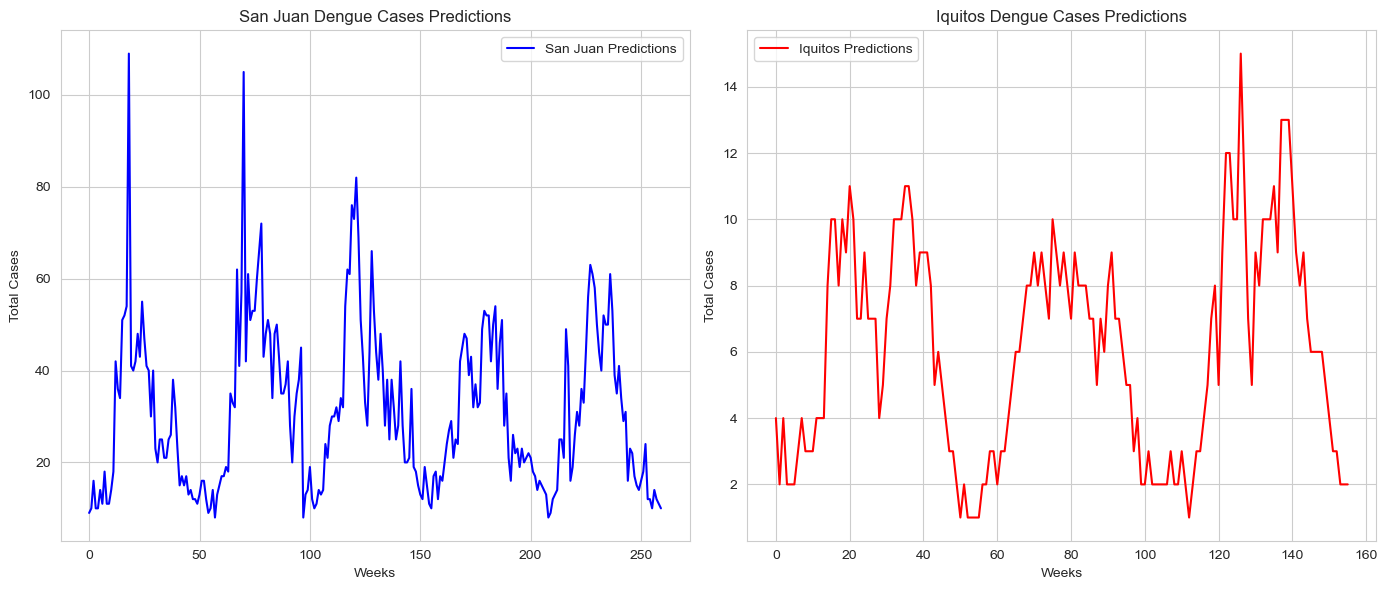

In [434]:
# Visualize the predictions for San Juan and Iquitos using two subplots with different colors
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(sj_pred, 'b', label='San Juan Predictions')
plt.title('San Juan Dengue Cases Predictions')
plt.xlabel('Weeks')
plt.ylabel('Total Cases')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(iq_pred, 'r', label='Iquitos Predictions')
plt.title('Iquitos Dengue Cases Predictions')
plt.xlabel('Weeks')
plt.ylabel('Total Cases')
plt.legend()

plt.tight_layout()
plt.show()



In [ ]:
submission = pd.read_csv('submission_format.csv', index_col=[0, 1, 2])
submission.total_cases = np.concatenate([sj_pred, iq_pred])
submission.to_csv("predict_result_rfr.csv")